In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
display.set_matplotlib_formats('svg')
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [ ]:
path = "train.csv"
df = pd.read_csv(path)
df.shape

(45597, 41)

In [ ]:
df.head()

,Id,Address,Sold Price,Summary,Type,Year built,Heating,Cooling,Parking,Lot,Bedrooms,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Region,Elementary School,Elementary School Score,Elementary School Distance,Middle School,Middle School Score,Middle School Distance,High School,High School Score,High School Distance,Flooring,Heating features,Cooling features,Appliances included,Laundry features,Parking features,Tax assessed value,Annual tax amount,Listed On,Listed Price,Last Sold On,Last Sold Price,City,Zip,State
0,0,540 Pine Ln,3825000.0,"540 Pine Ln, Los Altos, CA 94022 is a single f...",SingleFamily,1969.0,"Heating - 2+ Zones, Central Forced Air - Gas","Multi-Zone, Central AC, Whole House / Attic Fan","Garage, Garage - Attached, Covered",1.0,"Ground Floor Bedroom, Master Bedroom on Ground...",0.0,NaN,1.0,0.0,0.0,Los Altos,Santa Rita Elementary School,7.0,0.4,NaN,NaN,NaN,Los Altos High School,8.0,1.3,"Tile, Hardwood, Carpet","Forced air, Gas",Central,"Dishwasher, Dryer, Garbage disposal, Microwave...","Washer / Dryer, Inside, In Utility Room","Garage, Garage - Attached, Covered",886486.0,12580.0,2019-10-24,4198000.0,NaN,NaN,Los Altos,94022.0,CA
1,1,1727 W 67th St,505000.0,"HURRY, HURRY.......Great house 3 bed and 2 bat...",SingleFamily,1926.0,Combination,"Wall/Window Unit(s), Evaporative Cooling, See ...","Detached Carport, Garage",4047.0,3,2.0,2.0,872.0,1.0,1.0,Los Angeles,Raymond Avenue Elementary School,3.0,0.8,John Muir Middle School,2.0,1.1,Augustus F. Hawkins High A Critical Design And...,2.0,1.3,NaN,Combination,"Wall/Window Unit(s), Evaporative Cooling, See ...",NaN,Inside,"Detached Carport, Garage",505000.0,6253.0,2019-10-16,525000.0,2019-08-30,328000.0,Los Angeles,90047.0,CA
2,2,28093 Pine Ave,140000.0,'THE PERFECT CABIN TO FLIP! Strawberry deligh...,SingleFamily,1958.0,Forced air,NaN,0 spaces,9147.0,2,3.0,1.0,1152.0,0.0,0.0,Strawberry,NaN,NaN,NaN,NaN,NaN,NaN,Long Barn High School,NaN,10.1,NaN,Forced air,NaN,NaN,NaN,NaN,49627.0,468.0,2019-08-25,180000.0,NaN,NaN,Strawberry,95375.0,CA
3,3,10750 Braddock Dr,1775000.0,Rare 2-story Gated 5 bedroom Modern Mediterran...,SingleFamily,1947.0,Central,Central Air,"Detached Carport, Driveway, Garage - Two Door",NaN,5,3.0,3.0,2612.0,0.0,0.0,Culver City,Farragut Elementary School,9.0,0.2,Culver City Middle School,7.0,0.2,Culver City High School,8.0,0.2,"Wood, Tile",Central,Central Air,Dishwasher,"Stackable, Upper Level","Detached Carport, Driveway, Garage - Two Door",1775000.0,20787.0,2019-10-24,1895000.0,2016-08-30,1500000.0,Culver City,90230.0,CA
4,4,7415 O Donovan Rd,1175000.0,Beautiful 200 acre ranch land with several pas...,VacantLand,NaN,NaN,NaN,0 spaces,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Creston,Santa Margarita Elementary School,6.0,8.5,Atascadero Middle School,5.0,10.2,Atascadero High School,6.0,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-07,1595000.0,2016-06-27,900000.0,Creston,93432.0,CA


# 1. Exploratory Data Analysis

To make predictions on price with high accuracy, we need to apply EDA to the dataset

1.1 First, check number of missing values in the dataset

In [ ]:
missing_val = df.isnull().sum()
missing_val

Id                                 0
Address                            0
Sold Price                         0
Summary                          334
Type                               0
Year built                       979
Heating                         6177
Cooling                        10196
Parking                          872
Lot                            13673
Bedrooms                        2730
Bathrooms                       3298
Full bathrooms                  7452
Total interior livable area     2421
Total spaces                     862
Garage spaces                    863
Region                             2
Elementary School               4533
Elementary School Score         4677
Elementary School Distance      4533
Middle School                  15952
Middle School Score            15952
Middle School Distance         15952
High School                     4820
High School Score               5004
High School Distance            4821
Flooring                       11046
H

1.2 Drop columns containing at least 30% missing values

In [ ]:
col_to_drop = df.columns[missing_val > len(df) * 0.3]
col_to_drop

Index(['Middle School', 'Middle School Score', 'Middle School Distance',
       'Last Sold On', 'Last Sold Price'],
      dtype='object')

In [ ]:
df.drop(columns=col_to_drop, inplace=True)
df.shape

(45597, 36)

1.3 Examine data types for columns

In [ ]:
df.dtypes

Id                               int64
Address                         object
Sold Price                     float64
Summary                         object
Type                            object
Year built                     float64
Heating                         object
Cooling                         object
Parking                         object
Lot                            float64
Bedrooms                        object
Bathrooms                      float64
Full bathrooms                 float64
Total interior livable area    float64
Total spaces                   float64
Garage spaces                  float64
Region                          object
Elementary School               object
Elementary School Score        float64
Elementary School Distance     float64
High School                     object
High School Score              float64
High School Distance           float64
Flooring                        object
Heating features                object
Cooling features         

1.4 Convert several columns from string to float

In [ ]:
monetary_val = ['Sold Price','Listed Price','Tax assessed value','Annual tax amount']
for a in monetary_val:
  df[a] = df[a].replace(
      #replace $ , - to whitespace
      r'[$,-]','', regex=True).replace(
          #replace whitespace to np.nan
          r'^\s*$',np.nan, regex=True).astype(float)

1.5 Now we check statistic summary for numerical columns

In [ ]:
df.describe()

,Id,Sold Price,Year built,Lot,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Elementary School Score,Elementary School Distance,High School Score,High School Distance,Tax assessed value,Annual tax amount,Listed Price,Zip
count,45597.000000,4.559700e+04,44618.000000,3.192400e+04,42299.000000,38145.000000,4.317600e+04,44735.000000,44734.000000,40920.000000,41064.000000,40593.000000,40776.000000,4.208100e+04,41438.000000,4.559600e+04,45596.000000
mean,22798.000000,1.304630e+06,1956.106078,2.346488e+05,2.354973,2.095766,5.932278e+03,1.550777,1.476193,5.731843,1.143164,6.141379,2.400481,7.916134e+05,10027.279333,1.324447e+06,93272.758334
std,13162.864449,1.683680e+06,142.370507,1.207698e+07,1.185909,0.964328,8.490159e+05,8.943987,8.895555,2.104718,2.326876,1.988162,3.605481,1.146449e+06,13790.038900,2.650266e+06,2269.334722
min,0.000000,1.005000e+05,0.000000,0.000000e+00,0.000000,1.000000,1.000000e+00,-15.000000,-15.000000,1.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,85611.000000
25%,11399.000000,5.750000e+05,1946.000000,4.965000e+03,2.000000,2.000000,1.185000e+03,0.000000,0.000000,4.000000,0.300000,5.000000,0.800000,2.589680e+05,3524.000000,5.800000e+05,90210.000000
50%,22798.000000,9.750000e+05,1967.000000,6.499000e+03,2.000000,2.000000,1.565000e+03,1.000000,1.000000,6.000000,0.500000,6.000000,1.300000,5.561490e+05,7235.000000,9.500000e+05,94114.000000
75%,34197.000000,1.538000e+06,1989.000000,1.045400e+04,3.000000,2.000000,2.141000e+03,2.000000,2.000000,7.000000,1.000000,8.000000,2.400000,9.450830e+05,12114.000000,1.499000e+06,95070.000000
max,45596.000000,9.000000e+07,2281.000000,1.897474e+09,24.000000,17.000000,1.764164e+08,1000.000000,1000.000000,10.000000,57.200000,10.000000,73.900000,4.590000e+07,552485.000000,4.025320e+08,96155.000000


The summary illustrates that there are outliers in columns *Year built, Bathrooms, Full bathrooms, Total interior livable area, Total spaces, and Garage spaces.*

Our goal is to remove as much noises in the dataset as we can, so that we are able to make prediction with high accuracy.

1.6 Filter out properties whose living areas are too small or too large

In [ ]:
area_val = ['Total interior livable area','Lot']
outliers = (df[area_val[1]] < 10 )| (df[area_val[1]] > 1e4)
df = df[~outliers]
sum(outliers)

8659

1.7 Visualize the distribution of Sold Price

[Text(0, 0, '1e+03'),
 Text(0, 0, '1e+04'),
 Text(0, 0, '1e+05'),
 Text(0, 0, '1e+06'),
 Text(0, 0, '1e+07'),
 Text(0, 0, '1e+08')]

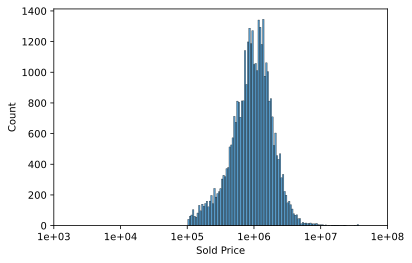

In [ ]:
ax = sns.histplot(np.log10(df['Sold Price']))
ax.set_xlim([3,8])
ax.set_xticks(range(3,9))
# 0 decimal place scientific notation
ax.set_xticklabels('%.0e'%a for a in 10**ax.get_xticks())

Based on the histogram above, we found that the majority houses value approximately 1 million USD. The price generally ranges from 100 thousand USD to 10 million USD.

1.8 Explore different types of housing

In [ ]:
df['Type'].value_counts()

SingleFamily                         21924
Condo                                 7855
Townhouse                             2128
Unknown                               1530
MultiFamily                           1226
                                     ...  
1 Level, Unit Above, Ground Floor        1
Attached                                 1
Split Level                              1
Luxury, Townhouse, 2 Level               1
Luxury, Townhouse                        1
Name: Type, Length: 148, dtype: int64

Based on the result, we will focus on types with the highest counts while excluding *Unknown*. Therefore, we extract *SingleFamily, Condo, Townhouse, MultiFamily, MobileManufactured, Apartment* for visualization.

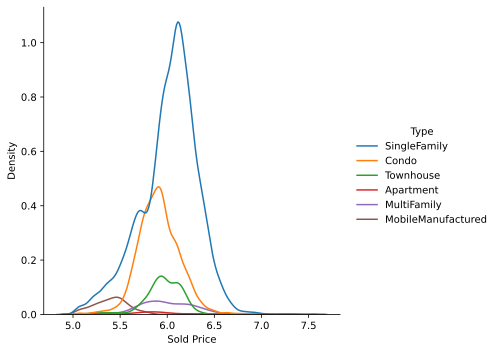

In [ ]:
types = df['Type'].isin(['SingleFamily','Condo','Townhouse',
                         'MultiFamily','MobileManufactured','Apartment'])
df_type = pd.DataFrame({'Type':df[types]['Type'],
                       'Sold Price':np.log10(df[types]['Sold Price'])})
# displot() connects to several different plot methods: histplot(), kdeplot(), ecdfplot()
# methods can be changed by different 'kind' values
dis = sns.displot(df_type, x = 'Sold Price', hue = 'Type', kind='kde')
dis.set_titles("Price density for different house types")

1.9 Explore sale price per living sqft between different house types

(0.0, 1800.0)

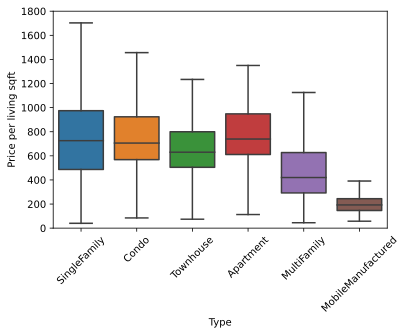

In [ ]:
df["Price per living sqft"] = df["Sold Price"] / df['Total interior livable area']
ax = sns.boxplot(x='Type',y="Price per living sqft", data = df[types], fliersize=0)
plt.xticks(rotation = 45)
ax.set_ylim([0,1800])

1.10 Now we explore the effect of location on housing prices. Location is one of the most influential factors on housing prices.

We focus on the pricing for top 20 zip codes.

In [ ]:
location = df[df['Zip'].isin(df['Zip'].value_counts()[:20].keys())]

KeyError: ignored

In [ ]:
ax = sns.boxplot(x = "Zip", y = "Price per living sqft", data = location, fliersize = 0)
ax.set_ylim([0,2000])
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 60)
plt.xticks(rotation = 60)

The boxplot demonstrated that 94114 has the highest price per living sqft while 95020 has the lowest price per living sqft among top 20 locations.

1.11 Last, we explore the correlation between features/variables and visualize correlations in a heatmap.

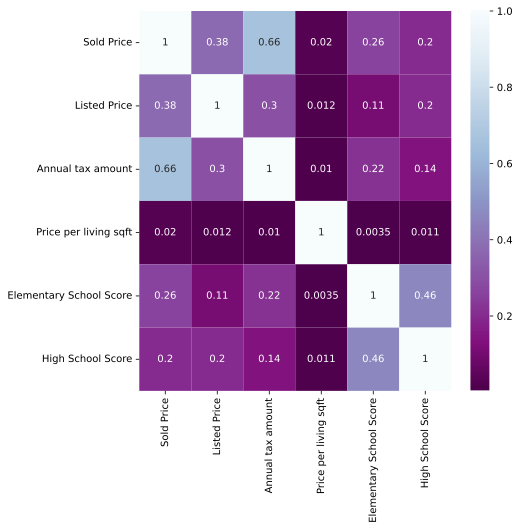

In [ ]:
_, ax = plt.subplots(figsize = (7,7))
features = ['Sold Price','Listed Price','Annual tax amount','Price per living sqft','Elementary School Score','High School Score']
sns.heatmap(df[features].corr(), annot=True, cmap = 'BuPu_r', ax = ax)